INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
600       Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
600       Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

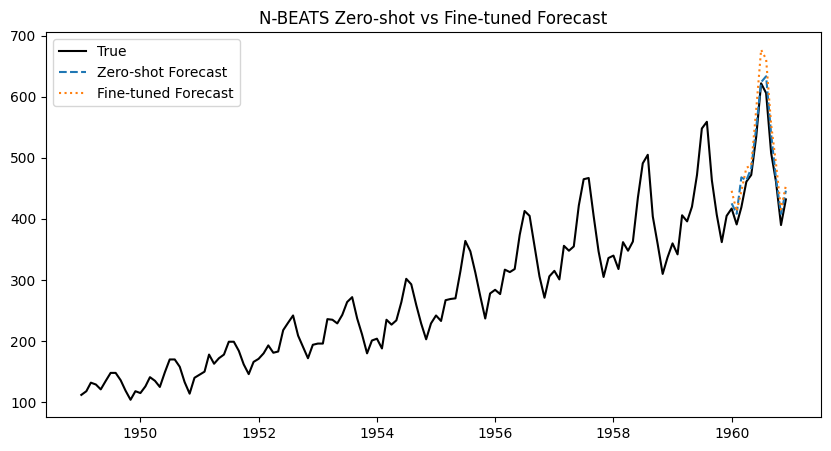

In [2]:
# Google Colab Compatible: Install Required Packages
!pip install -q neuralforecast datasets matplotlib

import torch
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast.models import NBEATS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE
from datasets import load_dataset
import pandas as pd

# Load a public time series dataset (monthly)
def load_air_passengers():
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url, parse_dates=['Month'])
    df.columns = ['ds', 'y']
    df['unique_id'] = 'air_passengers'
    return df

# Split dataset
def train_test_split(df, test_size=12):
    train = df[:-test_size]
    test = df[-test_size:]
    return train, test

# Prepare dataset for NeuralForecast
def prepare_nbeats_data(df, input_size=12, horizon=12):
    return df, input_size, horizon

# Define and train N-BEATS model
def train_nbeats(train_df, input_size, horizon, max_steps=500):
    model = NBEATS(h=horizon, input_size=input_size, loss=MAE(), max_steps=max_steps)
    nf = NeuralForecast(models=[model], freq='M')
    nf.fit(df=train_df)
    return nf


# Predict with zero-shot and fine-tuned models
def forecast(nf_model, test_df, horizon):
    forecast_df = nf_model.predict()
    forecast_y = forecast_df.iloc[-horizon:]['NBEATS']
    return forecast_y.values

# Main pipeline
df = load_air_passengers()
train_df, test_df = train_test_split(df)

# Simulating pretraining on train_df
train_df, input_size, horizon = prepare_nbeats_data(train_df)
pretrained_model = train_nbeats(train_df, input_size, horizon)

# Zero-shot forecast
zero_shot_preds = forecast(pretrained_model, test_df, horizon)

# Fine-tuning: simulate by retraining on full data
finetuned_model = train_nbeats(df, input_size, horizon)
finetuned_preds = forecast(finetuned_model, test_df, horizon)

# Compare forecasts
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='True', color='black')
plt.plot(test_df['ds'], zero_shot_preds, label='Zero-shot Forecast', linestyle='--')
plt.plot(test_df['ds'], finetuned_preds, label='Fine-tuned Forecast', linestyle=':')
plt.legend()
plt.title("N-BEATS Zero-shot vs Fine-tuned Forecast")
plt.show()
